In [0]:
''' This file contains the model used to Classify Particles'''

import os
import numpy as np
import tensorflow as tf
import keras
import keras.metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
#from keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scipy import ndimage
from sklearn.metrics import confusion_matrix
import h5py


class ParticleClassifier():
    def __init__(self):
        '''x and y is after preprocessing'''
        self.path = None
        self.images = None
        self.labels = None
        self.images_train = None
        self.images_test = None
        self.labels_train = None
        self.labels_test = None
        self.x = None
        self.y = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.images_attacked = None
        self.labels_attacked = None
        self.x_attacked = None
        self.y_attacked = None
        self.predictions = None
        self.attacked_predictions = None
        self.misclassifications = None
        self.images_mis_orig = None
        self.images_mis_attacked = None
        self.pred_mis_orig = None
        self.pred_mis_attacked = None
        self.report_dict = None
        
        self.model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 50x50 with 1 bytes color
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(50, 50, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
        ])
        
        self.messages = {'load_data': 'Data loaded into self.images, self.labels',
                         'train_test_split': 'Split into self.images_train, self.images_test, self.labels_train, self.labels_test',
                         'pre_proc_train': 'Train images pre-processed into self.x_train',
                         'pre_proc_test': 'Test images pre-processed into self.x_test',
                         'one_hot_encode': 'Train and test labels encoded into self.y_train and self.y_test',
                         'train_model': 'Model trained.',
                         'gen_hot_channel_data': 'Hot channel data generated in self.images_attacked, self.labels_attacked, self.x_attacked, self.y_attacked'}
            
        
    def __call__(self):
        return
        
    def load_data(self, path='data/toy_data.csv'):
        '''Loads data from path into self.labels and self.images'''
        self.path = path
        data = np.genfromtxt(path, delimiter=',')
        self.labels = data[:,0].astype(int)
        self.images = data[:, 1:].reshape((len(data),50,50,1))
        print(self.messages['load_data'])
        return self
    
    def train_test_split(self, images=None, labels=None, test_size=0.2):
        '''Wrapper around train_test_split'''
        if images is None:
            images = self.images
        if labels is None:
            labels = self.labels
        self.images_train, self.images_test, self.labels_train, self.labels_test = \
        train_test_split(images, labels, test_size=test_size)
        print(self.messages['train_test_split'])
        return self
        
    def pre_proc_filter(self, images, size=2, sigma=2):
        '''Applies Median filter and Gaussian filter to remove noise and hot
        channels. Size refers to size of Median filter, sigma refers to Gaussian
        filter parameter - larger for more blurring.
        Parameters
        ----------
        size: int, optional 
        sigma: int, optional
        '''
        orig_shape = images.shape
        images_new = []
        for image in images.reshape((images.shape[0:-1])):        
            image_new = ndimage.median_filter(image, size=size, mode='wrap')
            image_new = ndimage.gaussian_filter(image_new, sigma=sigma)
            images_new.append(image_new)
        return np.array(images_new).reshape(orig_shape)
    
    def pre_proc_rescale(self, images, negative=False):
        '''Subtract the mean, scales all image to between -1 and 1, and remove
        all negative values (if False).
        '''
        orig_shape = images.shape
        images_reshaped = images.reshape((orig_shape[0], -1))
        images_scaled = np.subtract(images_reshaped, np.median(images_reshaped, axis=1, keepdims=True))
        if not negative:
            images_scaled[images_scaled < 0] = 0.
        images_scaled = np.divide(images_scaled, np.max(images_scaled, axis=1, keepdims=True))
        images_scaled = images_scaled.reshape(orig_shape)
        return images_scaled
    
    def pre_proc(self, images, size=2, sigma=2, filters=False, rescale=True):
        '''Helper function that removes applies pre-processing to givem images.
        '''
        x = images.copy()
        if filters:
            x = self.pre_proc_filter(x, size=size, sigma=sigma)
        if rescale:
            x = self.pre_proc_rescale(x)
        return x
    
    def pre_proc_images(self, filters=False, rescale=True, 
                        train=False, test=False, attacked=False, size=2, sigma=2):
        '''Pre-processes any of the 3 image sets (train, test, attacked).
        Filters indicate if Median and Gaussian filters should be applied. 
        Rescale indicate if images should be rescaled.'''
        if train:
            self.x_train = self.pre_proc(self.images_train, size=size, 
                                         sigma=sigma, filters=filters, 
                                         rescale=rescale)
        if test:
            self.x_test = self.pre_proc(self.images_test, size=size, sigma=sigma,
                                        filters=filters, rescale=rescale)
        if attacked:
            self.x_attacked = self.pre_proc(self.images_attacked, size=size,
                                            sigma=sigma, filters=filters, 
                                            rescale=rescale)
        return self
    
    def one_hot_encode_labels(self, train=False, test=False, attacked=False):
        '''One hot encodes any of the 3 label sets (train, test, attacked).'''
        if train:
            self.y_train = to_categorical(self.labels_train)
        if test:
            self.y_test = to_categorical(self.labels_test)
        if attacked:
            self.y_attacked = to_categorical(self.labels_attacked)
        print(self.messages['one_hot_encode'])
        return self

        
    def train_model(self, x=None, y=None, val_split=0.2, epochs=10, verbose=1,
                    callback=None, min_delta=0.02, patience=5):
        '''Trains CNN model.'''
        if x is None:
            x = self.x_train
        if y is None:
            y = self.y_train
        if callback is None:
            self.callback = EarlyStopping(monitor='val_loss',
                                      min_delta=min_delta,
                                      patience=patience)
            
        self.model.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['acc'])
        
        self.model.fit(x,
                      y,  
                      epochs=epochs,
                      verbose=verbose,
                      validation_split=val_split,
                      callbacks=[self.callback])
        print(self.messages['train_model'])
        return self
    
    def save_model(self, name):
        self.model.save(name)
        return self
        
    def load_model(self, name):
        self.model = tf.keras.models.load_model(name)
        return self
    
    def evaluate_model(self, x_test=None, y_test=None):
        '''Evaluate model against test set'''
        if x_test is None:
            x_test = self.x_test
        if y_test is None:
            y_test = self.y_test
        self.model.evaluate(x_test, y_test)
        y_pred = self.model.predict(x_test)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
        return self
    
    def gen_hot_channel_data(self, images=None, labels=None, value=None):
        '''Adds a hot channel with double the max value at a random location 
        for each image.'''
        change_self = False
        if images is None:
            images = self.images_test
            change_self = True
        if labels is None:
            labels = self.labels_test
        if value is None:
            value = np.max(images) * 2
        loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
        images_edited = images.copy()
        images_edited[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = value
        self.images_attacked = images_edited
        self.x_attacked = self.pre_proc(self.images_attacked)
        self.labels_attacked = labels
        self.y_attacked = self.one_hot_encode_labels(labels)
        print(self.messages['gen_hot_channel_data'])
        return self
    
    def evaluate_attack(self, x=None, x_attacked=None, labels=None, labels_attacked=None, 
                        table=True, confusion_matrix=True, file_name=False):
        '''Evaluates the 
        against predictions without attack. Test data is used by default'''
        if x is None:
            x = self.x_test
            x_attacked = self.x_attacked
            images = self.images_test
            images_attacked = self.images_attacked
            labels = self.labels_test
            labels_attacked = self.labels_attacked
        original_pred = np.argmax(self.model.predict(x), axis=1).astype(int)
        attacked_pred = np.argmax(self.model.predict(x_attacked), axis=1).astype(int)
        self.predictions = original_pred
        self.attacked_predictions = attacked_pred
        self.misclassifications = np.invert(np.equal(original_pred, attacked_pred))
        self.images_mis_orig = images[self.misclassifications]
        self.images_mis_attacked = images_attacked[self.misclassifications]
        self.pred_mis_orig = original_pred[self.misclassifications]
        self.pred_mis_attacked = attacked_pred[self.misclassifications]
        if table:
            print('Labels: {} \n Original Predictions: {} \n Attacked Predictions: {}'\
                  .format(np.bincount(labels_attacked), np.bincount(original_pred),
                          np.bincount(attacked_pred)))
            print(classification_report(original_pred, attacked_pred)) 
        if confusion_matrix:
            correct_classifications = np.equal(labels, original_pred)
            self.generate_confusion_matrix(correct_classifications, file_name)
        self.report_dict = classification_report(original_pred, attacked_pred, 
                                                 output_dict=1)
        return self
    
    def apply_attack(self, attack, images=None, labels=None, gaussian_noise=False, **kwargs):
        '''Update images_attacked and labels_attacked after applying attack
        on an image set (test by default). '''
        if images is None:
            images = self.images_test
        if labels is None:
            labels = self.labels_test
        images_edited = images.copy()
        images_edited = attack(images_edited, **kwargs)
        if gaussian_noise:
            images_edited = self.add_gaussian_noise(images_edited, 50,  3)
        self.images_attacked = images_edited
        self.labels_attacked = labels
        return self
    
    def add_gaussian_noise(self, images, mu, sigma):
        '''Adds Gaussian noise for a given image, with mean = mu and standard
        deviation = sigma.
        :param images (n, x, y, 1)
        :param mu float
        :param sigma float'''
        gauss = np.random.normal(mu, sigma, size=images.shape)
        return images.copy() + gauss
        
    def add_hot_area(self, images, size, value=None, pos=None):
        '''Adds a hot channel at a given location pos=(x, y) with 
        size (i, j) for a given image.
        :param images (n, x, y, 1)
        :param pos (x, y), x and y are arrays of length n
        :param size (i, j)
        :param value to be replaced'''
        images_att = images.copy()
        if pos is None:
            x = np.random.randint(0, images.shape[1]-size[0],
                                  size=(images.shape[0],1))
            y = np.random.randint(0, images.shape[2]-size[1], 
                                  size=(images.shape[0], 1))
            pos = np.concatenate([x, y], axis=1)
        if value is None:
            value = images.max()
        for i in range(size[0]):
            for j in range(size[1]):
                images_att[np.arange(images_att.shape[0]), pos[:,0]+i, 
                           pos[:,1]+j, 0] = value
        return images_att
    
    def hot_pixel_attack(self, images=None, labels=None, value=None):
        if images is None:
            images = self.images_test
        if labels is None:
            labels = self.labels_test
        if value is None:
            value = np.max(images) * 2
            
        loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
        self.apply_attack(self.add_hot_area, images, labels, gaussian_noise=False,
                          size=[1,1], value=value, pos=loc)
        return self
        
    
    def print_image(self, index, image_set, file_name=False):
        '''Shows the nth image of an 4d image set of n images: (n, height, length, channel)'''
        if type(image_set) is not list:
            image_set = [image_set]
        for images in image_set:
            plt.imshow(images[index,:,:,0])
            plt.colorbar()
            if file_name:
                plt.savefig(file_name, bbox_inches='tight')
            plt.show()
        return self
        
    def show_misclassified_images(self, index, file_name=False):
         for i in index:
             if file_name:
                org = '_orig.'.join(file_name.split('.'))
                atk = '_attacked.'.join(file_name.split('.'))
             else:
                org = False
                atk = False
             self.print_image(i, self.images_mis_orig, 
                              file_name=org)
             self.print_image(i, self.images_mis_attacked, 
                             file_name=atk)
             print('{}, {}'.format(self.pred_mis_orig[i],
                                   self.pred_mis_attacked[i]))
         return self
     
    def generate_confusion_matrix(self, index, savefig):
        labels = ['background', 'electron', 'muon']
        cm = confusion_matrix(self.predictions[index],
                              self.attacked_predictions[index]).astype(np.float)
        for i in range(len(cm)):
            cm[i,:] = cm[i,:]/cm[i,:].sum()
        plt.rcParams.update({'axes.labelsize': 12,
                             'xtick.labelsize': 12,
                             'ytick.labelsize': 12})
        fig, ax = plt.subplots()
        im = ax.imshow(cm, cmap='summer')
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
        ax.set_xlabel('After Attack')
        ax.set_ylabel('Before Attack')
        ax.set_xticks(np.arange(3))
        ax.set_yticks(np.arange(3))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set_xticks(np.arange(3)-0.5, minor=True)
        ax.set_yticks(np.arange(3)-0.5, minor=True)
        
        for i in range(len(cm)):
            for j in range(len(cm[0])):
                text = ax.text(j, i, '%.3f'%cm[i, j], ha='center', 
                               va='center', color='black', size=15)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=4)
        fig.tight_layout()
        if savefig:
            plt.savefig(savefig)
        else:
            plt.show()

Using TensorFlow backend.


In [0]:
classifier = ParticleClassifier()\
                .load_data('/content/drive/My Drive/Year 3/BSc Project - Adversarial Attacks in CNN/toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True)\
                .one_hot_encode_labels(train=True, test=True)\
                .load_model('/content/drive/My Drive/Year 3/BSc Project - Adversarial Attacks in CNN/model.h5')

OSError: ignored

In [0]:
# dead channel attack - target the max pixel in each picture

def dead_channel(n, plot = True):
  old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
  if plot == True:
    plt.imshow(classifier.x_test[n][:,:,0])
    plt.show()
  img_copy = classifier.x_test[n].copy()
  (a, b) = np.unravel_index(np.argmax(classifier.x_test[n][:,:,0]), (50, 50))
  # [a, b] = np.random.randint(0, 50, size = 2)    # random location
  new_val = 0
  img_copy[a, b] = new_val                      # edit the location/how you wanna attack here
  new_pred = np.argmax(classifier.model.predict(img_copy.reshape((1, 50, 50, 1))))
  if plot == True:
    plt.imshow(img_copy[:,:,0])
    plt.show()
    print('Old prediction', old_pred, ',', 'New prediction', new_pred)
  return [old_pred, new_pred]
 
index_success = [] 
for i in range(600):
  [old_pred, new_pred] = dead_channel(i, plot = False)
  if old_pred != new_pred:
    index_success.append(i)
    
if len(index_success) == 0:
  print("No successful attacks")
else:
  print(len(index_success), "successful attack(s) out of 600 attacks, giving", len(index_success)/6, "%")

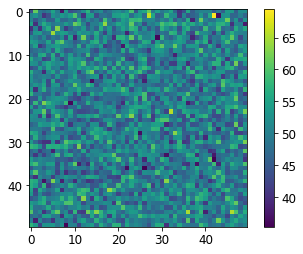

In [0]:
noise = np.random.normal(50, 5, size=(50,50))
plt.imshow(noise[:,:])
plt.colorbar()
plt.show()
 

In [0]:
# for the model - apply attack
def dead_channel_model(images, c, d):
        '''
        Alters the track of the particle (based on the max value of each image)
        :param c, vertical componenent
        :param d, horizontal component
        '''
        for i in images:
          (a, b) = np.unravel_index(np.argmax(i[:,:,0]), (50, 50,))
          noise = np.random.normal(50, 5, size=(50,50, 1))
          i[a- c:a+ c, b-d: b+d] = noise[a- c:a+ c, b-d: b+d]        # edit c and d here
        return images

In [0]:
def dead_channel_model_one(images):
        '''
        Alters the track of the particle (based on the max value of each image)
        :param c, vertical componenent
        :param d, horizontal component
        '''
        for i in images:
          (a, b) = np.unravel_index(np.argmax(i[:,:,0]), (50, 50,))
          noise = np.random.normal(50, 5, size=(50,50, 1))
          i[a,b] = noise[a,b]        
        return images

Train and test labels encoded into self.y_train and self.y_test
Labels: [202 215 183] 
 Original Predictions: [205 215 180] 
 Attacked Predictions: [221 175 204]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       205
           1       1.00      0.81      0.90       215
           2       0.81      0.92      0.86       180

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.92      0.91      0.91       600



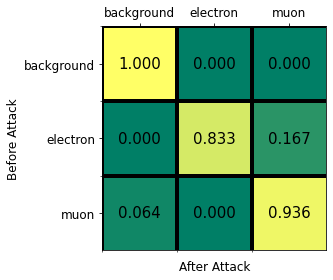

In [0]:
# the max pixel becomes dead
classifier.apply_attack(dead_channel_model_one).pre_proc_images(attacked=True).one_hot_encode_labels(attacked=True).evaluate_attack()


Train and test labels encoded into self.y_train and self.y_test
Labels: [207 185 208] 
 Original Predictions: [207 185 208] 
 Attacked Predictions: [233 111 256]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       207
           1       1.00      0.60      0.75       185
           2       0.72      0.88      0.79       208

    accuracy                           0.84       600
   macro avg       0.87      0.83      0.83       600
weighted avg       0.86      0.84      0.83       600



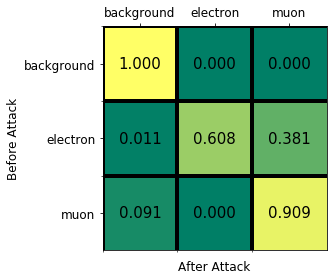

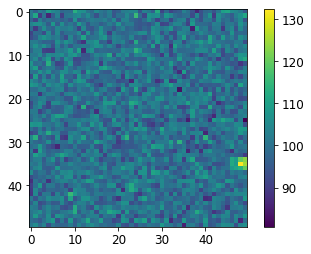

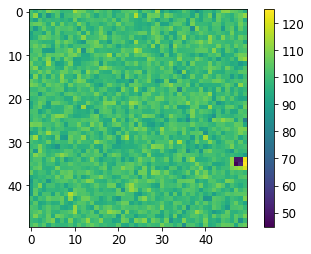

1, 2


In [0]:
# 2 by 2 pixels become dead
classifier.apply_attack(dead_channel_model, c = 1 , d = 1).pre_proc_images(attacked=True).one_hot_encode_labels(attacked=True).evaluate_attack().show_misclassified_images([3]) 

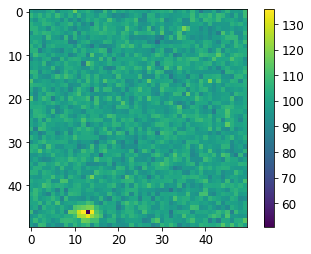

In [0]:
x_test = classifier.images_attacked[4] 
plt.imshow(x_test[:,:, 0])
plt.colorbar()
plt.show()

Train and test labels encoded into self.y_train and self.y_test
Labels: [194 213 193] 
 Original Predictions: [197 208 195] 
 Attacked Predictions: [275  42 283]
              precision    recall  f1-score   support

           0       0.72      1.00      0.83       197
           1       1.00      0.20      0.34       208
           2       0.58      0.85      0.69       195

    accuracy                           0.67       600
   macro avg       0.77      0.68      0.62       600
weighted avg       0.77      0.67      0.61       600



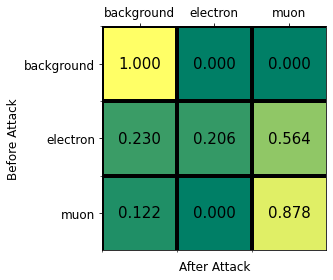

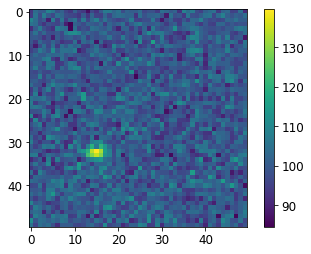

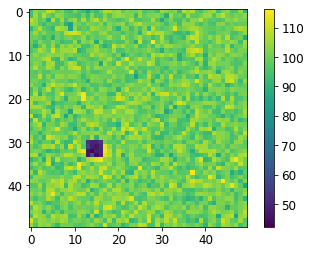

1, 0


In [0]:
# 4 by 4 pixel become dead
classifier.apply_attack(dead_channel_model, c = 2 , d = 2).pre_proc_images(attacked=True).one_hot_encode_labels(attacked=True).evaluate_attack().show_misclassified_images([2]) 

Train and test labels encoded into self.y_train and self.y_test
Labels: [194 213 193] 
 Original Predictions: [197 208 195] 
 Attacked Predictions: [385  18 197]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       197
           1       1.00      0.09      0.16       208
           2       0.78      0.79      0.79       195

    accuracy                           0.61       600
   macro avg       0.76      0.63      0.54       600
weighted avg       0.77      0.61      0.53       600



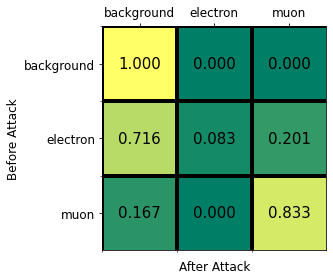

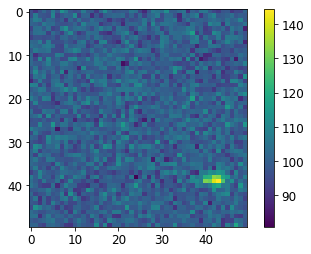

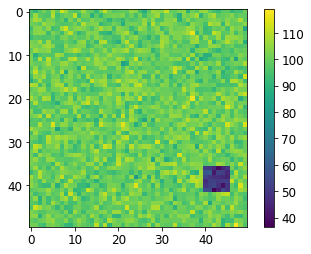

1, 0


In [0]:
# 6 by 6 pixel dead
classifier.apply_attack(dead_channel_model, c = 3 , d = 3).pre_proc_images(attacked=True).one_hot_encode_labels(attacked=True).evaluate_attack().show_misclassified_images([2]) 

Train and test labels encoded into self.y_train and self.y_test
Labels: [207 185 208] 
 Original Predictions: [207 185 208] 
 Attacked Predictions: [583   0  17]
              precision    recall  f1-score   support

           0       0.35      0.98      0.51       207
           1       0.00      0.00      0.00       185
           2       0.41      0.03      0.06       208

    accuracy                           0.35       600
   macro avg       0.25      0.34      0.19       600
weighted avg       0.26      0.35      0.20       600



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


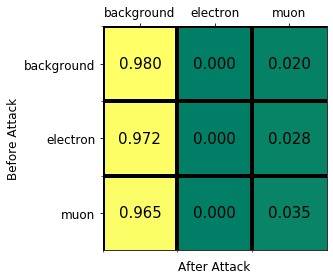

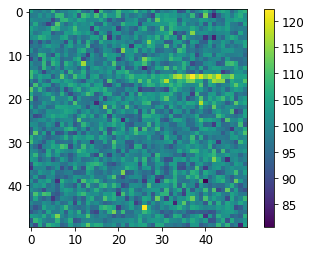

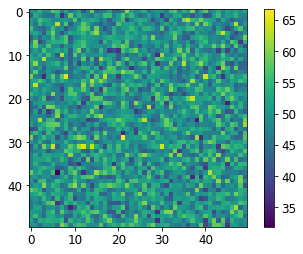

2, 0


In [0]:
# all pixels dead attack
def dead_channel_model_2(images):
        '''
        Alters the track of the particle (based on the max value of each image)
        :param c, vertical componenent
        :param d, horizontal component
        '''
        for i in images:
          (a, b) = np.unravel_index(np.argmax(i[:,:,0]), (50, 50))
          noise = np.random.normal(50, 5, size=(50,50, 1))
          i[:, :] = noise[:, :] 
        return images

classifier.apply_attack(dead_channel_model_2).pre_proc_images(attacked=True).one_hot_encode_labels(attacked=True).evaluate_attack().show_misclassified_images([2])


Train and test labels encoded into self.y_train and self.y_test
Labels: [207 185 208] 
 Original Predictions: [207 185 208] 
 Attacked Predictions: [229 137 234]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       207
           1       1.00      0.74      0.85       185
           2       0.79      0.89      0.84       208

    accuracy                           0.88       600
   macro avg       0.90      0.88      0.88       600
weighted avg       0.90      0.88      0.88       600



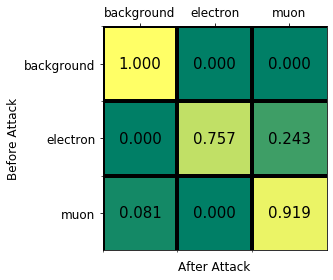

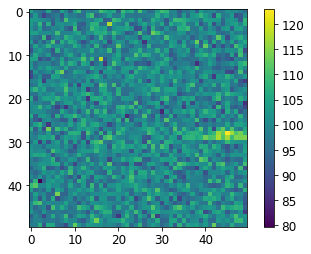

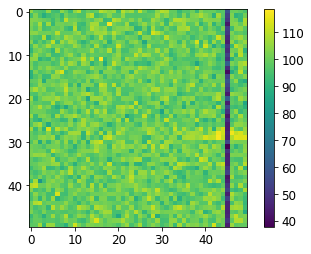

2, 0


In [0]:
# all vertical pixels dead attack
def dead_channel_model_3(images):
        '''
        Alters the track of the particle (based on the max value of each image)
        :param c, vertical componenent
        :param d, horizontal component
        '''
        for i in images:
          (a, b) = np.unravel_index(np.argmax(i[:,:,0]), (50, 50))
          noise = np.random.normal(50, 5, size=(50,50, 1))
          i[:, b] = noise[:, b]       
        return images

classifier.apply_attack(dead_channel_model_3).pre_proc_images(attacked=True).one_hot_encode_labels(attacked=True).evaluate_attack().show_misclassified_images([2])


Train and test labels encoded into self.y_train and self.y_test
Labels: [207 185 208] 
 Original Predictions: [207 185 208] 
 Attacked Predictions: [395  16 189]
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       207
           1       1.00      0.09      0.16       185
           2       0.14      0.12      0.13       208

    accuracy                           0.41       600
   macro avg       0.55      0.40      0.33       600
weighted avg       0.54      0.41      0.33       600



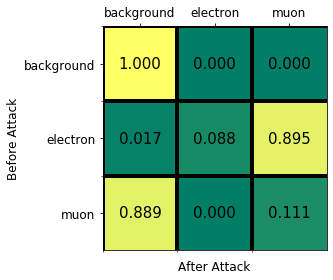

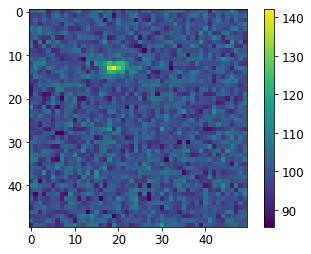

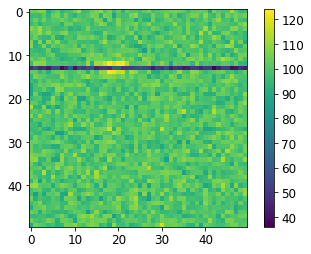

1, 2


In [0]:
# all horizontal pixels dead attack
def dead_channel_model_4(images):
        '''
        Alters the track of the particle (based on the max value of each image)
        :param c, vertical componenent
        :param d, horizontal component
        '''
        for i in images:
          (a, b) = np.unravel_index(np.argmax(i[:,:,0]), (50, 50))
          noise = np.random.normal(50, 5, size=(50,50, 1))
          i[a, :] = noise[a, :]        
        return images

classifier.apply_attack(dead_channel_model_4).pre_proc_images(attacked=True).one_hot_encode_labels(attacked=True).evaluate_attack().show_misclassified_images([2])


1
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0 529  71]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.36      1.00      0.53       190
           2       0.68      0.25      0.36       195

    accuracy                           0.40       600
   macro avg       0.35      0.42      0.30       600
weighted avg       0.33      0.40      0.28       600



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


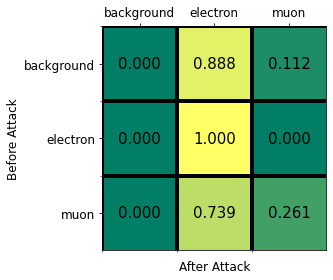

2
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0 397 203]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.48      0.99      0.64       190
           2       0.49      0.51      0.50       195

    accuracy                           0.48       600
   macro avg       0.32      0.50      0.38       600
weighted avg       0.31      0.48      0.37       600



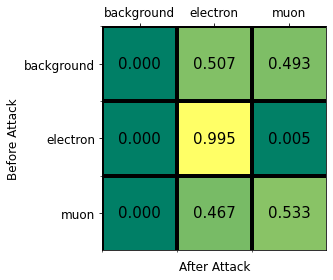

3
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0 343 257]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.54      0.97      0.69       190
           2       0.49      0.64      0.55       195

    accuracy                           0.52       600
   macro avg       0.34      0.54      0.41       600
weighted avg       0.33      0.52      0.40       600



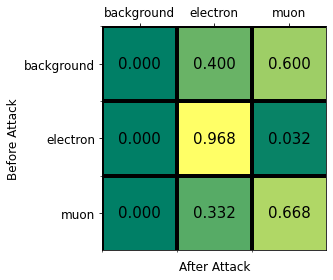

4
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0 281 319]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.57      0.84      0.68       190
           2       0.44      0.72      0.54       195

    accuracy                           0.50       600
   macro avg       0.34      0.52      0.41       600
weighted avg       0.32      0.50      0.39       600



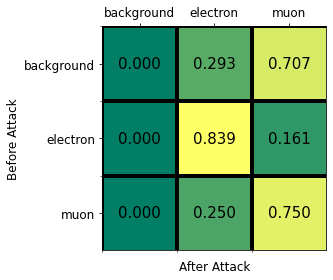

5
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0 198 402]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.53      0.55      0.54       190
           2       0.38      0.79      0.52       195

    accuracy                           0.43       600
   macro avg       0.30      0.45      0.35       600
weighted avg       0.29      0.43      0.34       600



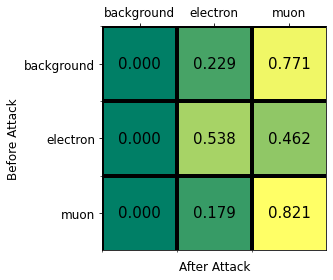

6
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0 126 474]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.40      0.27      0.32       190
           2       0.34      0.84      0.49       195

    accuracy                           0.36       600
   macro avg       0.25      0.37      0.27       600
weighted avg       0.24      0.36      0.26       600



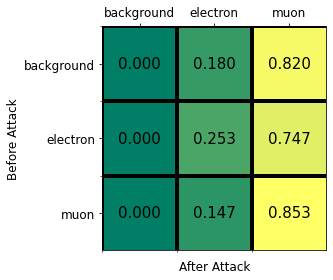

7
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0 100 500]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.34      0.18      0.23       190
           2       0.34      0.86      0.48       195

    accuracy                           0.34       600
   macro avg       0.23      0.35      0.24       600
weighted avg       0.22      0.34      0.23       600



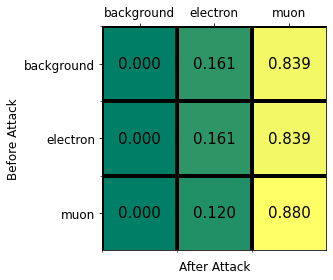

8
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0  90 510]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.32      0.15      0.21       190
           2       0.34      0.88      0.49       195

    accuracy                           0.33       600
   macro avg       0.22      0.34      0.23       600
weighted avg       0.21      0.33      0.22       600



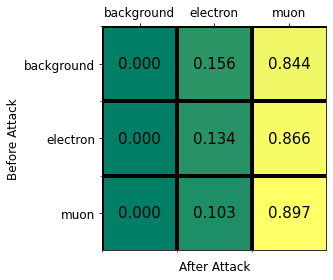

9
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0  83 517]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.31      0.14      0.19       190
           2       0.33      0.88      0.48       195

    accuracy                           0.33       600
   macro avg       0.22      0.34      0.22       600
weighted avg       0.21      0.33      0.22       600



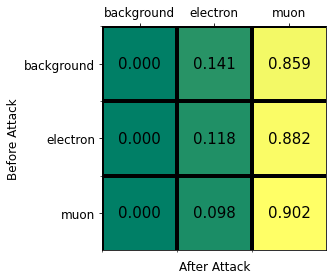

10
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0  77 523]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.31      0.13      0.18       190
           2       0.33      0.88      0.48       195

    accuracy                           0.33       600
   macro avg       0.21      0.34      0.22       600
weighted avg       0.21      0.33      0.21       600



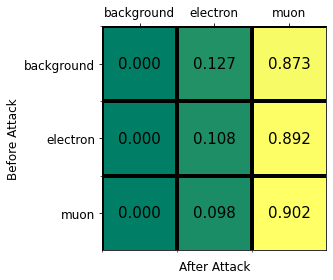

11
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0  74 526]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.32      0.13      0.18       190
           2       0.33      0.89      0.48       195

    accuracy                           0.33       600
   macro avg       0.22      0.34      0.22       600
weighted avg       0.21      0.33      0.21       600



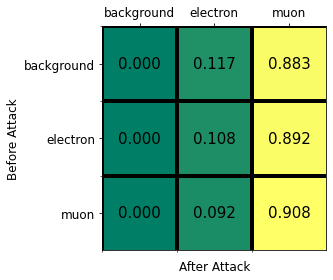

12
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0  73 527]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.33      0.13      0.18       190
           2       0.33      0.89      0.48       195

    accuracy                           0.33       600
   macro avg       0.22      0.34      0.22       600
weighted avg       0.21      0.33      0.21       600



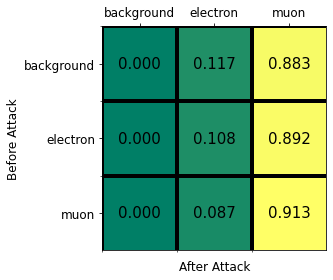

13
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0  72 528]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.32      0.12      0.18       190
           2       0.33      0.89      0.48       195

    accuracy                           0.33       600
   macro avg       0.22      0.34      0.22       600
weighted avg       0.21      0.33      0.21       600



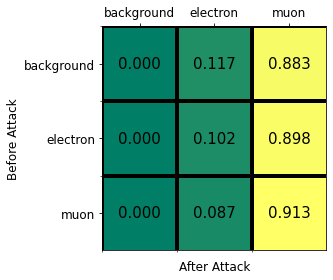

14
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0  72 528]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.32      0.12      0.18       190
           2       0.33      0.89      0.48       195

    accuracy                           0.33       600
   macro avg       0.22      0.34      0.22       600
weighted avg       0.21      0.33      0.21       600



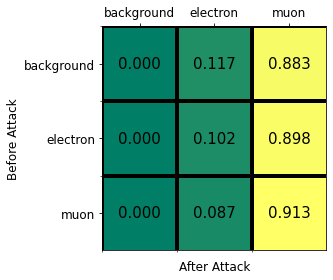

15
Train and test labels encoded into self.y_train and self.y_test
Labels: [207 195 198] 
 Original Predictions: [215 190 195] 
 Attacked Predictions: [  0  71 529]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.32      0.12      0.18       190
           2       0.33      0.89      0.48       195

    accuracy                           0.33       600
   macro avg       0.22      0.34      0.22       600
weighted avg       0.21      0.33      0.21       600



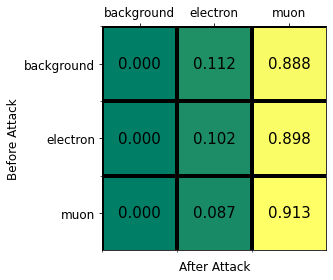

In [0]:
# for crack attack - not related to dead channel !!

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd

# Find pos to add crack
def crack_pos(size, images_orig):
    images = images_orig.copy()
    images = images.reshape(len(images), 2500)
    argmax = np.argmax(images, 1)
    pos = [list(np.unravel_index(i, (50,50))) for i in argmax]
    for xy in pos:
        if 50-xy[0] <= size[0]:
            xy[0] -= size[0]
        if 50-xy[1] <= size[1]:
            xy[1] -= size[1]
    return np.array(pos)

crack_results = []
for n in range(1, 16):
    print(n)
    size = (1, n)
    pos = crack_pos(size, classifier.images_test)
    classifier.apply_attack(classifier.add_hot_area, size=size, pos=pos)\
              .pre_proc_images(attacked=True, filters=False)\
              .one_hot_encode_labels(attacked=True)\
              .evaluate_attack(confusion_matrix=1)
    #classifier.show_misclassified_images([0])
    df = pd.DataFrame(classifier.report_dict).reset_index()
    df['n'] = n
    crack_results.append(df)
crack_results = pd.concat(crack_results)